In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import MEstimateEncoder
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
import regression as reg
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR 
from IPython.display import display

In [ ]:
#Reading the dataset
df = pd.read_csv('data/cleaned_cars.csv')
df = pd.get_dummies(df, columns = ['country'], drop_first=True, dtype=np.int8)
df.head()

## Target encoding

In [ ]:
X = df.copy()
y = X.pop('price')

X_encode = X.sample(frac=0.2, random_state=42)
y_encode = y[X_encode.index]
X = X.drop(X_encode.index)
y = y[X.index]

#Creating the encoder instance.
encoder = MEstimateEncoder(cols=["brand"], m=5.0)

#Fitting the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

#Encoding the Zipcode column to create the final training data
X = encoder.transform(X)
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)  

X.head()

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
#Splitting the dataset into training (60%) and temporary (40%) sets with a fixed random_state
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

#Splitting the temporary set into validation (50% of temporary, i.e., 20% of total) and test (50% of temporary, i.e., 20% of total) sets with the same random_state
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
#Scaling the input features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## No API part

In [ ]:
w = reg.linear_regression_fit(X_train_scaled, y_train)
y_predict = reg.linear_regression_predict(X_test_scaled, w)


In [ ]:
# Calculate mean squared error
mse = mean_squared_error(y_predict, y_test)
print(f"Mean Squared Error: {mse}")

In [ ]:
num_iterations = 1000
w, errors = reg.gradient_descent(X_train_scaled, y_train, 0.01, num_iterations)
print(w.shape)
y_predict = reg.linear_regression_predict(X_test_scaled, w)
mean_squared_error(y_predict, y_test)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), errors)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Gradient Descent Error')
plt.legend()
plt.show()

## Regression Models Implementation(API)

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)

In [ ]:
lasso = Lasso()
lasso.fit(X_train_scaled, y_train)

In [ ]:
ridge = Ridge()
ridge.fit(X_train_scaled, y_train)

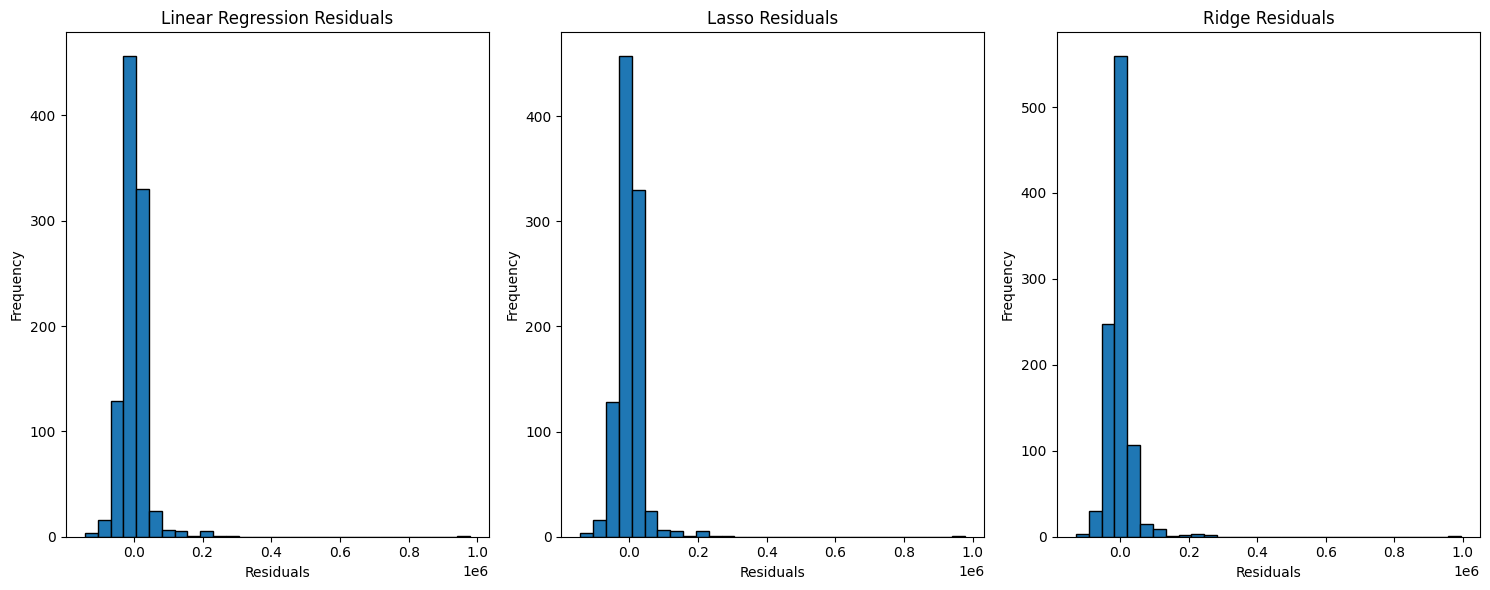

In [30]:
#Visualizing 
y_pred_lin_val = lin_model.predict(X_val_scaled)
y_pred_lasso_val = lasso.predict(X_val_scaled)
y_pred_ridge_val = ridge.predict(X_val_scaled)

residuals_lin_val = y_val - y_pred_lin_val
residuals_lasso_val = y_val - y_pred_lasso_val
residuals_ridge_val = y_val - y_pred_ridge_val
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].hist(residuals_lin_val, bins=30, edgecolor='black')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Linear Regression Residuals')
axes[1].hist(residuals_lasso_val, bins=30, edgecolor='black')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Lasso Residuals')
axes[2].hist(residuals_ridge_val, bins=30, edgecolor='black')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Ridge Residuals')
plt.tight_layout()
plt.show()

In [ ]:
#Implemnting Polynomial Regression and Testing Degrees
max_degree = 5
n = len(y_train)
k = X_train_scaled.shape[1]
bic_scores = []  
mse_scores = []
mae_scores = []
r2_scores = []
degrees = range(2, max_degree + 1)
#Testing BIC score for multiple degrees
for degree in degrees:

    poly = PolynomialFeatures(degree=degree)
    x_train_poly = poly.fit_transform(X_train_scaled)
    x_val_poly = poly.fit_transform(X_val_scaled)
    model = LinearRegression()
    model.fit(x_train_poly, y_train)
    y_val_pred = model.predict(x_val_poly)
    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    rss = np.sum((y_val - y_val_pred) ** 2)
    n = len(y_val)
    k = x_val_poly.shape[1]
    bic = k * np.log(rss / n) + k * np.log(n)
    bic_scores.append(bic)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
results_df = pd.DataFrame({
    'Degree': degrees,
    'MSE': mse_scores,
    'MAE': mae_scores,
    'R2': r2_scores,
    'BIC': bic_scores
})

plt.figure(figsize=(10, 6))
plt.plot(degrees, bic_scores, marker='o', label='BIC Score')
plt.xlabel('Polynomial Degree')
plt.ylabel('BIC Score')
plt.title('Polynomial Degree vs. BIC Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Polynomial Regression Model with degree = 2
poly_features = PolynomialFeatures(degree=2)
x_train_poly = poly_features.fit_transform(X_train_scaled)
poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)

In [ ]:
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

In [ ]:
#Function for Evaluating different models and saving the results in a dictionary
def evaluate_models(models, x_vali, y_vali):
    results = {}

    for model_name, model in models:
        if model_name == 'Polynomial Regression':
            poly_features = PolynomialFeatures(degree=2)
            x_poly = poly_features.fit_transform(x_vali)
            y_pred = model.predict(x_poly)
        else:
            y_pred = model.predict(x_vali)

        mae = mean_absolute_error(y_vali, y_pred)
        mse = mean_squared_error(y_vali, y_pred)
        r2 = r2_score(y_vali, y_pred)

        results[model_name] = {'MAE': mae, 'MSE': mse, 'R2': r2}

    return results

In [ ]:
#Evaluating Models Before Hyperparamater Tuning
models = [
    ('Lasso', lasso),
    ('Ridge', ridge),
    ('Linear Regression', lin_model),
    ('Polynomial Regression', poly_model),
    ('SVR', svr)
]

results_without_tuning = evaluate_models(models, X_val_scaled, y_val)

In [ ]:
display(results_without_tuning)

In [ ]:
# Hyperparamater Values
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

In [ ]:
#Using Grid Search to find the optimal value for alpha on lasso
lasso_cv = GridSearchCV(lasso,param_grid,cv = 5,n_jobs = -1)
lasso_cv.fit(X_train_scaled, y_train)

In [ ]:
#Using Grid Search to find the optimal value for alpha on ridge
ridge_cv = GridSearchCV(ridge,param_grid,cv = 5,n_jobs = -1)
ridge_cv.fit(X_train_scaled, y_train)

In [ ]:
svr_param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
              }  

In [ ]:
#Using Grid Search to find the optimal value for alpha on svr
grid_search = GridSearchCV(SVR(kernel='rbf'), svr_param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
svr_best = grid_search.best_estimator_

In [ ]:
#Evaluating Models After Hyperparameter Tuning
tuned_models = [
    ('Lasso', lasso_cv),
    ('Ridge', ridge_cv),
    ('SVR', svr_best)
]

tuned_results = evaluate_models(tuned_models, X_val_scaled, y_val)

In [ ]:
display(tuned_results)

In [ ]:
#Applying the Test Set on Lasso
display(evaluate_models([('Lasso', lasso_cv)], X_test_scaled, y_test))

## Forward Feature Selection

In [ ]:
#Implementing Forward Feature Selection with Lasso Model
def forward_feature_selection(X_train, y_train, X_val, y_val,model,scoring='mse', max_features=None):

    selected_features = []
    remaining_features = list(range(X_train.shape[1]))
    validation_scores = []

    if max_features is None:
        max_features = X_train.shape[1]

    best_score = float('inf') if scoring in ['mse', 'mae'] else float('-inf')

    for _ in range(max_features):
        best_feature = None
        best_feature_score = best_score

        for feature in remaining_features:
            features_to_test = selected_features + [feature]
            X_train_subset = X_train[:, features_to_test]
            X_val_subset = X_val[:, features_to_test]

            model.fit(X_train_subset, y_train)

            y_val_pred = model.predict(X_val_subset)

            if scoring == 'mse':
                score = mean_squared_error(y_val, y_val_pred)
                is_better = score < best_feature_score  
            elif scoring == 'mae':
                score = mean_absolute_error(y_val, y_val_pred)
                is_better = score < best_feature_score
            elif scoring == 'r2':
                score = model.score(X_val_subset, y_val)
                is_better = score > best_feature_score  
            else:
                raise ValueError("Unsupported scoring metric. Use 'mse' or 'r2'.")

            if is_better:
                best_feature_score = score
                best_feature = feature

        if best_feature is not None:
            selected_features.append(best_feature)
            validation_scores.append(best_feature_score)
            remaining_features.remove(best_feature)
            best_score = best_feature_score 
        else:
            break  

    return selected_features, validation_scores

In [ ]:
selected_features, validation_scores = forward_feature_selection(
    X_train_scaled, y_train, X_val_scaled, y_val, scoring='r2', max_features=3, model=lasso_cv
)

# Output the results
print("Selected Features:", selected_features)
print("Validation Scores:", validation_scores)

## This Section is for trying a NEW target variable : top_speed

In [ ]:
X_new = df.copy()
y_new = X_new.pop('top_speed')

X_encode_new = X_new.sample(frac=0.2, random_state=42)
y_encode_new = y_new[X_encode_new.index]

X_new = X_new.drop(X_encode_new.index)
y_new = y_new[X_new.index]

brand_counts = X_encode_new['brand'].value_counts()  
X_new['brand'] = X_new['brand'].map(brand_counts) 


X_new.reset_index(drop=True, inplace=True)
y_new.reset_index(drop=True, inplace=True)

X_new.dropna(inplace=True)
y_new = y_new[X_new.index]

In [ ]:
# Split the dataset into training (60%) and temporary (40%) sets with a fixed random_state
X_train_new, X_temp_new, y_train_new, y_temp_new = train_test_split(X_new, y_new, test_size=0.4, random_state=42)

# Split the temporary set into validation (50% of temporary, i.e., 20% of total) and test (50% of temporary, i.e., 20% of total) sets with the same random_state
X_val_new, X_test_new, y_val_new, y_test_new = train_test_split(X_temp_new, y_temp_new, test_size=0.5, random_state=42)


In [ ]:
#Scaling the input features
scaler_new = MinMaxScaler()
X_train_scaled_new = scaler_new.fit_transform(X_train_new)
X_val_scaled_new = scaler_new.transform(X_val_new)
X_test_scaled_new = scaler_new.transform(X_test_new)

In [ ]:
lin_model_new = LinearRegression()
lin_model_new.fit(X_train_scaled_new, y_train_new)
lasso_new = Lasso()
lasso_new.fit(X_train_scaled_new, y_train_new)
ridge_new = Ridge()
ridge_new.fit(X_train_scaled_new, y_train_new)
poly_features_new = PolynomialFeatures(degree=2)
x_train_poly_new = poly_features_new.fit_transform(X_train_scaled_new)
poly_model_new = LinearRegression()
poly_model_new.fit(x_train_poly_new, y_train_new)
svr_new = SVR(kernel='rbf')
svr_new.fit(X_train_scaled_new, y_train_new)

In [ ]:
models_new = [
    ('Lasso', lasso_new),
    ('Ridge', ridge_new),
    ('Linear Regression', lin_model_new),
    ('Polynomial Regression', poly_model_new),
    ('SVR', svr_new)
]

results_new = evaluate_models(models_new, X_val_scaled_new, y_val_new)

In [ ]:
display(results_new)